# Convolution

In [1]:
import numpy as np
import os
from ipywidgets import IntProgress
from scipy.signal import convolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ['HOME']

'/home/borundev'

In [3]:
im=plt.imread(os.environ['HOME']+'/Downloads/patna-actress-vidya-balan-addresses-during-programme_fe51ec38-5f3b-11e9-a01d-452d93af50a1.jpg')

In [4]:
f1 = np.array([[-1, 0, 1],
                [-1,0,1],
                [-1,0,1]])
f2 = np.array([[1, 1, 1],
                [0,0,0],
                [-1,-1,-1]])

In [5]:
rand_filter=np.random.rand(3,3)
rand_filter

array([[0.83685021, 0.87485443, 0.93843417],
       [0.84496375, 0.55795504, 0.09744812],
       [0.53103976, 0.96800142, 0.04018031]])

In [6]:
l1_filters=np.stack([f1,f2,rand_filter])

In [7]:
new_images=np.array([[convolve(im[:,:,c],l1_filters[i,::-1,::-1],'same','direct').clip(0,255)\
                      .astype(np.int) for c in range(3)] for i in range(len(l1_filters))])

In [8]:
new_images=new_images.transpose(0,2,3,1)

In [9]:
all_images=np.concatenate([im[None],new_images])

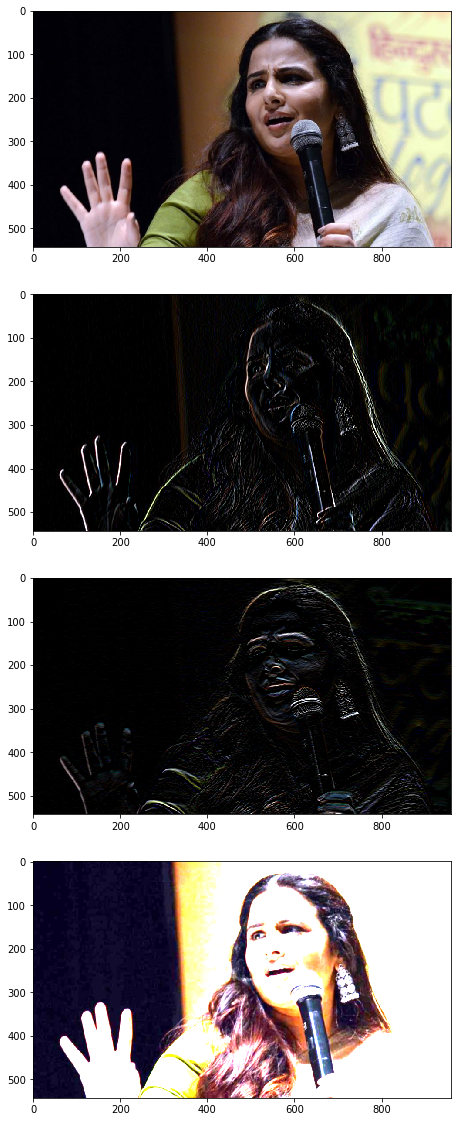

In [10]:
_,axs=plt.subplots(len(all_images),1,figsize=(10,20))
for ax,img in zip(axs,all_images):
    ax.imshow(img)

Mathematically convolution is usually defined as follows

$$
(f*g)(x) = \int dy f(x-y) g(y)
$$

with an obvious discrete generalization. This essentially means that the value of the convolution at $x$ is the weighted average of the value of $f$ at $x-y$ with weight $g(y)$. From the point of view of image processing this is a bit backwards in that for a convolution window of length $K$ we would want the convolution at $x$ to be the average of $f$ such that the value at $x-K/2+y$ is weighted by $g(y)$. So the expression is

$$
(f*g)(x) = \int dy f(x+y-K/2) g(y)
$$

We will use scipy.convolve so it is useful to understand the way it is related to what we want. Scipy's convolve is for signal processing so it resembles the conventional definition but because of numpy convention of starting an array location as 0, the center of the window of $g$ is not at 0 but at $K/2$. So scipy uses the definition

$$
(f*g)(x) = \int dy f(x-y) g(y+K/2) \\
=\int dy f(x-y+K/2)g(y)
$$

Now we if reverse the scipy convolution window we have $y \to K-y$ and that make the integral

$$
(f*g)(x) =\int dy f(x+y-K/2)g(K-y)
$$

Thus we will get the result we want by giving the flipped array of the convolution window to scipy convolve.

We will compute a Hann window convolution on a square window with the above expression and also do it using scipy as it is faster and we want to understand the convention scipy uses vis-a-vis our expression.

In [11]:
from scipy import signal
sig = np.repeat([0., 0.5,1., 0.], 100)

In [12]:
win=np.ones(50)
win[:25]=-1

Text(0.5, 1.0, 'signal')

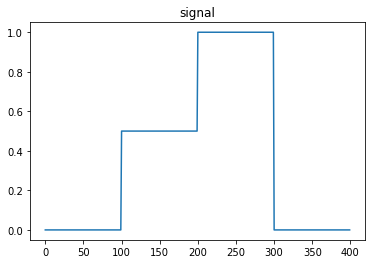

In [13]:
plt.plot(sig)
plt.title('signal')

Text(0.5, 1.0, 'Convolution Filter')

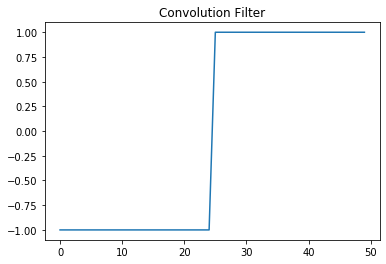

In [14]:
plt.plot(win)
plt.title('Convolution Filter')

In [15]:
class array_padder(object):
    def __init__(self,x,k):
        self.l=len(x)
        self.k=k
        self.x=np.pad(x,(k,k),'constant',constant_values=(0,0))
    
    def __getitem__(self,k):
        
        def modify_slice(s,k):
            return slice(s.start+k,s.stop+k,s.step)
        
        if isinstance(k,int):
            return self.x[self.k+k]
        else:
            return self.x[modify_slice(k,self.k)]
        
sig_embedding=array_padder(sig,50)


Text(0.5, 1.0, 'convolution done by hand')

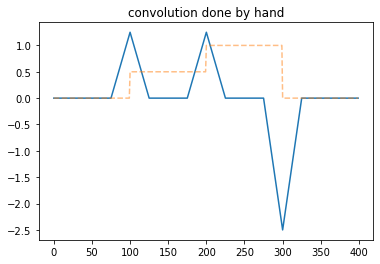

In [16]:
k=25
plt.plot(np.array([(sig_embedding[i-k:50+i-k]*win).sum()/10 for i in range(len(sig))]))
plt.plot(sig,"--",alpha=.5)
plt.title('convolution done by hand')


Text(0.5, 1.0, 'convolution done by scipy')

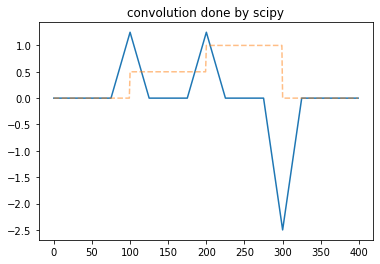

In [17]:
plt.plot(convolve(sig,win[::-1]/10,'same'))
plt.plot(sig,"--",alpha=.5)
plt.title('convolution done by scipy')


Now we are ready to apply all this to CNNs. We denote the data for the image we want to convolute as $l^{n-1}_{ij}$ and the convolution filter as $W^n_{\alpha,\beta}$. The dimension of the convolution window is taken to be $K$. Then we have from the discussion above the output of the convolution as

$$
l^n_{ij} = f^n( \sum_{\alpha,\beta=0}^{K-1} l^{n-1}_{i+\alpha-K//2,j+\beta-K//2} W^n_{\alpha \beta}  )
$$

Since numpy interprets negative indices differently, a useful trick is to embed the image in a bigger array with size $K//2$ extended on either side for each dimension with zero padding. 

$$
\tilde l^{n-1}_{i+K//2,j+K//2} = l^n_{ij}
$$



With this, in the expanded image we get

$$
l^n_{ij} = f^n( \sum_{\alpha,\beta=0}^{K-1} \tilde l^{n-1}_{i+\alpha,j+\beta} W^n_{\alpha \beta}  )
$$

# Two class classification

Now lets make a simple CNN model. We will have monochrome images coming in with size $L \times L$ . We will apply a single convolution filter (that will be learned). The resulting image will still be size $L \times L$ and then we will apply a dense layer (that will also be learnt) on it and then use a sigmoid function.




Concretely, we have as input an image $l^0_{ij}$ that we first embed in a bigger image padding with zeros

$$
\tilde l^0_{i+K//2,j+K//2}=l^0_{ij}
$$

Then we pass it through a convolutional layer and an activation function $f^1$ that we will take to be Relu

$$
l^1_{ij} = f^1 ( \sum_{\alpha,\beta=0}^{K-1} \tilde l^{0}_{i+\alpha,j+\beta} W^1_{\alpha \beta}  ) \\
= Relu( \sum_{\alpha,\beta=0}^{K-1} \tilde l^{0}_{i+\alpha,j+\beta} W^1_{\alpha \beta}  )
$$
where $Relu(x) = x \Theta(x)$ and its derivative is $Relu'(x) = \Theta(x)$. Here $\Theta$ is the step function.

Then we make a dense layer wrapped in some function (which in this case we take to be a sigmoid function)

$$
l^2 = f^2( \sum_{ij} l^1_{ij} W^2_{ij}) \\
= s( \sum_{ij} l^1_{ij} W^2_{ij})
$$

where 

$$
s(x) = \frac{1}{1-e^{-x}}
$$


The loss function is 

$$
L= -y*\log(l^2) - (1-y)*\log(1-l^2)
$$

Thus we have

$$
\frac{\partial L}{\partial l^2}= \frac{l^2(1-y) - (1-l^2)y}{l^2(1-l^2)}
$$

Then we have

$$
\frac{\partial L}{\partial W^2_{ij}} = \frac{\partial L}{\partial l^2} \frac{\partial f^2}{\partial W^2_{ij}} \\
= \frac{l^2(1-y) - (1-l^2)y}{l^2(1-l^2)} l^2 (1-l^2) l^1_{ij} \\
= (l^2(1-y) - (1-l^2)y) l^1_{ij}
$$
where we have used the fact that $l^2$ is the output of the sigmoid function and that $s'(x)=s(x)(1-s(x))$.

Similarly

$$
\frac{\partial L}{\partial l^1_{ij}} = (l^2(1-y) - (1-l^2)y) W^2_{ij}
$$

Finally

$$
\frac{\partial L}{\partial W^1_{\alpha \beta}} = \sum_{ij} \frac{\partial L}{\partial l^1_{ij}} (f^1)' \tilde l^0_{i+\alpha,j+\beta}\\
 = \sum_{ij} \frac{\partial L}{\partial l^1_{ij}} \Theta(\sum_{\alpha,\beta=0}^{K-1} \tilde l^{0}_{i+\alpha,j+\beta} W^1_{\alpha \beta}  ) \tilde l^0_{i+\alpha,j+\beta}
$$


Note that we have all the expressions in closed form.

In [91]:
from tensorflow import keras
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [92]:
X_train_full=X_train_full[np.any([y_train_full==1,y_train_full==3],0)]
y_train_full=y_train_full[np.any([y_train_full==1,y_train_full==3],0)]

In [93]:
X_test=X_test[np.any([y_test==1,y_test==3],0)]
y_test=y_test[np.any([y_test==1,y_test==3],0)]

In [94]:
y_train_full=(y_train_full==3).astype(int)
y_test=(y_test==3).astype(int)

In [95]:
X_train, X_valid = X_train_full[:-1000], X_train_full[-1000:]
y_train, y_valid = y_train_full[:-1000], y_train_full[-1000:]

In [96]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

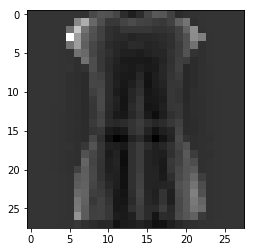

In [97]:
plt.imshow(X_train[0,:,:],cmap="gray")

In [98]:
def relu(x):
    return np.where(x>0,x,0)
    
def relu_prime(x):
    return np.where(x>0,1,0)

def sigmoid(x):
    return 1./(1.+np.exp(-x))


In [99]:
from functools import wraps

def coroutine(func):
    @wraps(func)
    def inner(*args,**kwargs):
        gen=func(*args,**kwargs)
        next(gen)
        return gen
    return inner

@coroutine
def averager():
    total=0
    count=0
    average=None
    cont=True
    while cont:
        val=yield average
        if val is None:
            cont=False
            continue
        else:
            total+=val
            count+=1.
            average=total/count
    return average

@coroutine
def timer(n):
    t0=time.time()
    cont=True
    remaining_time_estimate=None
    d=0
    while True:
        z=yield remaining_time_estimate
        d+=1
        if d>n:
            break
        t1=time.time()
        dt=t1-t0
        avg_time=dt/d
        projected_time=n*avg_time
        remaining_time_estimate=(n-d)*avg_time
        
        
def extract_averager_value(averager):
    try:
        averager.send(None)
    except StopIteration as e:
        return e.value
    
    


In [105]:
K=3
image_size=X_train.shape[1]
image_size_embedding_size=image_size+K-1

np.random.seed(42)
W1=np.random.rand(K,K)
W2=np.random.normal(0,1/np.sqrt(image_size*image_size),size=(image_size*image_size))

In [106]:
W1_original=W1.copy()
W2_original=W2.copy()

In [107]:
def forward_pass(W1,W2,X,y):
    l0=X
    lt0=np.zeros((l0.shape[0]+K-1,l0.shape[1]+K-1))
    lt0[K//2:-K//2+1,K//2:-K//2+1]=l0
    l0_conv=convolve(l0,W1[::-1,::-1],'same','direct')

    l1=relu(l0_conv)
    f1p=relu_prime(l0_conv)


    l2=sigmoid(np.dot(l1.reshape(-1,),W2))
    l2=l2.clip(10**-16,1-10**-16)


    loss=-(y*np.log(l2)+(1-y)*np.log(1-l2))
    accuracy=int(y==np.where(l2>0.5,1,0))

    return l1,l2,accuracy,loss

In [ ]:
from ipywidgets import IntProgress
w=IntProgress(max=len(y_train))
display(w)
eta=.001

for epoch in range(5):
    train_loss=averager()
    train_accuracy=averager()
    
    for i in range(len(y_train)):
        
        # Take a random sample
        k=np.random.randint(len(y_train))
        X=X_train[k]
        y=y_train[k]
        if (i+1) % 100 ==0:
            w.value=i+1
        

        # First layer is just the input
        l0=X
        
        # Embed the image in a bigger image. It would be useful in computing corrections to the convolution
        # filter
        lt0=np.zeros((l0.shape[0]+K-1,l0.shape[1]+K-1))
        lt0[K//2:-K//2+1,K//2:-K//2+1]=l0
        
        # convolve with the filter
        l0_conv=convolve(l0,W1[::-1,::-1],'same','direct')
        
        # Layer one is Relu applied on the convolution 
        l1=relu(l0_conv)
        
        # Also compute derivative of layer 1
        f1p=relu_prime(l0_conv)

        # Compute layer 2
        l2=sigmoid(np.dot(l1.reshape(-1,),W2))
        l2=l2.clip(10**-16,1-10**-16)
        
        # Loss and Accuracy
        loss=-(y*np.log(l2)+(1-y)*np.log(1-l2))
        accuracy=int(y==np.where(l2>0.5,1,0))
        
        # Save the loss and accuracy to a running averager
        train_loss.send(loss)
        train_accuracy.send(accuracy)

        # Derivative of loss wrt the dense layer
        dW2=(((1-y)*l2-y*(1-l2))*l1).reshape(-1,)
        
        # Derivative of loss wrt the output of the first layer
        dl1=(((1-y)*l2-y*(1-l2))*W2).reshape(28,28)
        
        # Derivative of the loss wrt the convolution filter
        dl1_f1p=dl1*f1p
        dW1=np.array([[(lt0[alpha:+alpha+image_size,beta:beta+image_size]*dl1_f1p).sum() for beta in range(K)] \
                          for alpha in range(K)])

        W2+=-eta*dW2
        W1+=-eta*dW1
    

    
    loss_averager_valid=averager()
    accuracy_averager_valid=averager()   
    
    for X,y in zip(X_valid,y_valid):
        _,_,accuracy,loss=forward_pass(W1,W2,X,y)
        loss_averager_valid.send(loss)
        accuracy_averager_valid.send(accuracy)
    
    train_loss,train_accuracy,valid_loss,valid_accuracy=map(extract_averager_value,[
                                                            train_loss,
                                                            train_accuracy,
                                                            loss_averager_valid,
                                                            accuracy_averager_valid]
                                                           )
    msg='Epoch {}: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(epoch+1,
                                                                                                      train_loss,
                                                                                                      train_accuracy,
                                                                                                      valid_loss,
                                                                                                      valid_accuracy
                                                                                                     )
    print(msg)

    
    

IntProgress(value=0, max=11000)

Epoch 1: train loss 0.27, train acc 0.94, valid loss 0.14, valid acc 0.95


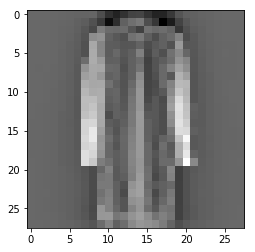

In [18]:
plt.imshow(l0,cmap='gray')

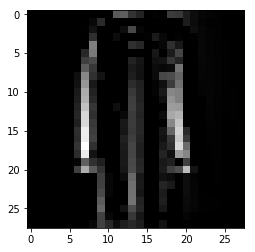

In [19]:
plt.imshow(l1,cmap='gray')

In [20]:
W1_original

array([[0.37454012, 0.95071431, 0.73199394],
       [0.59865848, 0.15601864, 0.15599452],
       [0.05808361, 0.86617615, 0.60111501]])

In [21]:
W1

array([[-0.11902524,  0.72963966,  0.46962929],
       [-0.14810388, -0.17924978, -0.33814714],
       [-0.78173108,  0.63249264,  0.27862479]])

In [24]:
W2.shape

(784,)

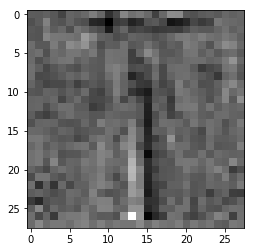

In [25]:
plt.imshow(W2.reshape(28,28),cmap='gray')

In [26]:
def plot_original_and_new_forward_pass(W1,W2,X,y):
    _,axs=plt.subplots(1,3,figsize=(7,2))

    axs[0].imshow(X,cmap='gray')

    l0=X
    l0_conv=convolve(l0,W1_original[::-1,::-1],'same','direct')

    l1=relu(l0_conv)
    f1p=relu_prime(l0_conv)


    l2=sigmoid(np.dot(l1.reshape(-1,),W2_original))
    l2=l2.clip(10**-16,1-10**-16)
    
    axs[1].imshow(l1,cmap='gray')
    
    l0_conv=convolve(l0,W1[::-1,::-1],'same','direct')

    l1=relu(l0_conv)
    f1p=relu_prime(l0_conv)


    l2=sigmoid(np.dot(l1.reshape(-1,),W2))
    l2=l2.clip(10**-16,1-10**-16)
    
    axs[2].imshow(l1,cmap='gray')
    plt.suptitle('y={}, l2={:.2f}'.format(y,l2))
        
        

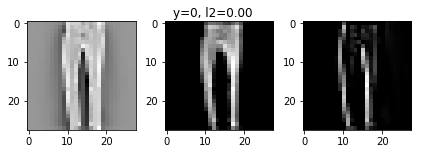

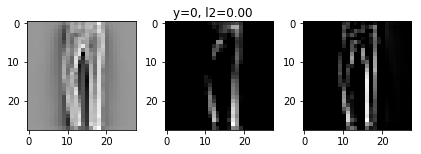

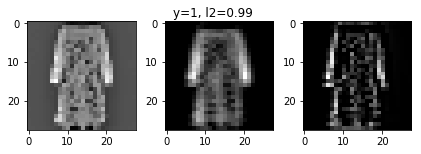

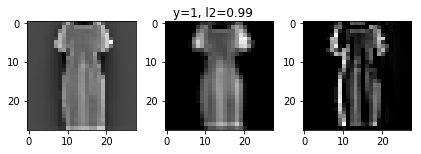

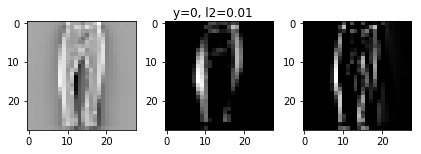

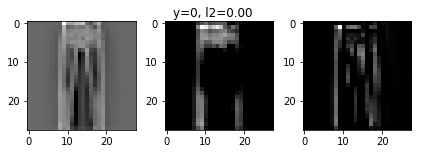

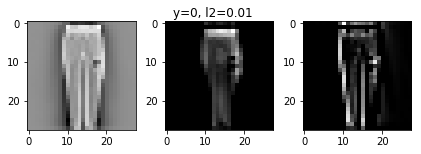

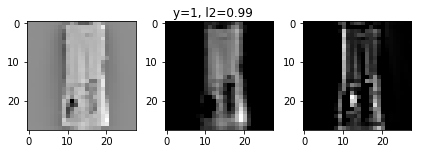

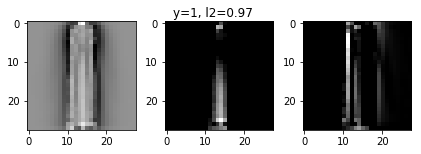

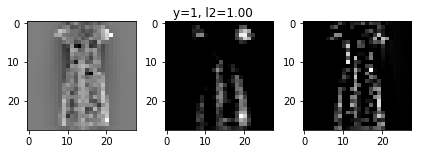

In [27]:
for i in np.random.randint(0,y_train.shape[0],10):
    X,y = X_train[i],y_train[i]
    plot_original_and_new_forward_pass(W1,W2,X,y)

## Freezing Layers

### Freezing the Convolutional Layer

In [29]:
K=3
np.random.seed(42)
W1=np.random.rand(K,K)
W2=np.random.normal(0,1/np.sqrt(28*28),size=(28*28))

In [30]:
from ipywidgets import IntProgress
w=IntProgress(max=len(y_train))
display(w)
eta=.001

for epoch in range(5):
    avg_loss=averager()
    for i in range(len(y_train)):
        k=np.random.randint(len(y_train))
        X=X_train[k]
        y=y_train[k]
        if (i+1) % 100 ==0:
            w.value=i+1
        

        l0=X
        lt0=np.zeros((l0.shape[0]+K-1,l0.shape[1]+K-1))
        lt0[K//2:-K//2+1,K//2:-K//2+1]=l0
        l0_conv=convolve(l0,W1[::-1,::-1],'same','direct')

        l1=relu(l0_conv)
        f1p=relu_prime(l0_conv)


        l2=sigmoid(np.dot(l1.reshape(-1,),W2))
        l2=l2.clip(10**-16,1-10**-16)
        

        loss=-(y*np.log(l2)+(1-y)*np.log(1-l2))

        a_loss=avg_loss.send(loss)


        dW2=(((1-y)*l2-y*(1-l2))*l1).reshape(-1,)
        dl1=(((1-y)*l2-y*(1-l2))*W2).reshape(28,28)
        dl1_f1p=dl1*f1p
        dW1=np.array([[(lt0[alpha:30+alpha-2,beta:30+beta-2]*dl1_f1p).sum() for beta in range(3)] for alpha in range(3)])

        W2+=-eta*dW2
        #W1+=-eta*dW1
    

    
    loss_averager_train=averager()
    accuracy_averager_train=averager()
    loss_averager_valid=averager()
    accuracy_averager_valid=averager()
    
    for X,y in zip(X_train,y_train):
        _,_,accuracy,loss=forward_pass(W1,W2,X,y)
        loss_averager_train.send(loss)
        accuracy_averager_train.send(accuracy)
    
    for X,y in zip(X_valid,y_valid):
        _,_,accuracy,loss=forward_pass(W1,W2,X,y)
        loss_averager_valid.send(loss)
        accuracy_averager_valid.send(accuracy)
    
    train_loss,train_accuracy,valid_loss,valid_accuracy=map(extract_averager_value,[
                                                            loss_averager_train,
                                                            accuracy_averager_train,
                                                            loss_averager_valid,
                                                            accuracy_averager_valid]
                                                           )
    msg='Epoch {}: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(epoch+1,
                                                                                                      train_loss,
                                                                                                      train_accuracy,
                                                                                                      valid_loss,
                                                                                                      valid_accuracy
                                                                                                     )
    print(msg)

    
    

IntProgress(value=0, max=11000)

/Users/borundev/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


Epoch 1: train loss 0.45, train acc 0.94, valid loss 0.45, valid acc 0.93
Epoch 2: train loss 0.45, train acc 0.94, valid loss 0.50, valid acc 0.93
Epoch 3: train loss 0.69, train acc 0.93, valid loss 0.74, valid acc 0.91
Epoch 4: train loss 0.27, train acc 0.95, valid loss 0.31, valid acc 0.93
Epoch 5: train loss 0.43, train acc 0.94, valid loss 0.60, valid acc 0.92


### Freezing the Dense Layer

In [33]:
K=3
np.random.seed(42)
W1=np.random.rand(K,K)
W2=np.random.normal(0,1/np.sqrt(28*28),size=(28*28))

In [34]:
from ipywidgets import IntProgress
w=IntProgress(max=len(y_train))
display(w)
eta=.001

for epoch in range(5):
    avg_loss=averager()
    for i in range(len(y_train)):
        k=np.random.randint(len(y_train))
        X=X_train[k]
        y=y_train[k]
        if (i+1) % 100 ==0:
            w.value=i+1
        

        l0=X
        lt0=np.zeros((l0.shape[0]+K-1,l0.shape[1]+K-1))
        lt0[K//2:-K//2+1,K//2:-K//2+1]=l0
        l0_conv=convolve(l0,W1[::-1,::-1],'same','direct')

        l1=relu(l0_conv)
        f1p=relu_prime(l0_conv)


        l2=sigmoid(np.dot(l1.reshape(-1,),W2))
        l2=l2.clip(10**-16,1-10**-16)
        

        loss=-(y*np.log(l2)+(1-y)*np.log(1-l2))

        a_loss=avg_loss.send(loss)


        dW2=(((1-y)*l2-y*(1-l2))*l1).reshape(-1,)
        dl1=(((1-y)*l2-y*(1-l2))*W2).reshape(28,28)
        dl1_f1p=dl1*f1p
        dW1=np.array([[(lt0[alpha:30+alpha-2,beta:30+beta-2]*dl1_f1p).sum() for beta in range(3)] for alpha in range(3)])

        #W2+=-eta*dW2
        W1+=-eta*dW1
    

    
    loss_averager_train=averager()
    accuracy_averager_train=averager()
    loss_averager_valid=averager()
    accuracy_averager_valid=averager()
    
    for X,y in zip(X_train,y_train):
        _,_,accuracy,loss=forward_pass(W1,W2,X,y)
        loss_averager_train.send(loss)
        accuracy_averager_train.send(accuracy)
    
    for X,y in zip(X_valid,y_valid):
        _,_,accuracy,loss=forward_pass(W1,W2,X,y)
        loss_averager_valid.send(loss)
        accuracy_averager_valid.send(accuracy)
    
    train_loss,train_accuracy,valid_loss,valid_accuracy=map(extract_averager_value,[
                                                            loss_averager_train,
                                                            accuracy_averager_train,
                                                            loss_averager_valid,
                                                            accuracy_averager_valid]
                                                           )
    msg='Epoch {}: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(epoch+1,
                                                                                                      train_loss,
                                                                                                      train_accuracy,
                                                                                                      valid_loss,
                                                                                                      valid_accuracy
                                                                                                     )
    print(msg)

    
    

IntProgress(value=0, max=11000)

Epoch 1: train loss 0.66, train acc 0.60, valid loss 0.69, valid acc 0.61
Epoch 2: train loss 0.66, train acc 0.60, valid loss 0.68, valid acc 0.61
Epoch 3: train loss 0.65, train acc 0.61, valid loss 0.67, valid acc 0.62
Epoch 4: train loss 0.64, train acc 0.62, valid loss 0.66, valid acc 0.63
Epoch 5: train loss 0.64, train acc 0.63, valid loss 0.66, valid acc 0.63


# Multiclass Classifier

$$
l^1_{ij Z}=f^1(\sum \tilde l^0_{i+\alpha,j+\beta;M} W^1_{\alpha\beta M Z})
$$


$$
l^2_\alpha = f^2( l^1_{ijZ} W^2_{ijZ\alpha})\\
= \frac{exp(l^1_{ijZ} W^2_{ijZ\alpha})}{\sum_\beta exp(l^1_{ijZ} W^2_{ijZ\beta})}
$$

and loss function is

$$
L =  - l^1_{ijZ} W^2_{ijZy} + \log( \sum_\alpha exp(l^1_{ijZ} W^2_{ijZ\alpha}))
$$


$$
\frac{\partial L}{\partial l^1_{ijZ}}=-W^2_{ijZy}+\sum W^2_{ijZ\alpha} l^2_\alpha
$$

$$
\frac{\partial L}{\partial W^2_{ijZ\beta}}=-l^1_{ijZ} \delta_{y \beta}+ l^1_{ijZ} l^2_\beta
$$


$$
\frac{\partial L}{\partial W^1_{\alpha \beta M Z}} = \sum_{ij} \frac{\partial L}{\partial l^1_{ijZ}} (f^1)' \tilde l^0_{i+\alpha,j+\beta;M}
$$


## Fashion MNIST

In [72]:
from tensorflow import keras
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [73]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [74]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [75]:
def batch_generator(X,y,batch_size,total_count):
    idx=np.arange(0,len(y))
    for i in range(total_count):
        idx_batch=np.random.choice(idx,batch_size)
        yield X[idx_batch],y[idx_batch]

In [76]:
def forward_pass_batch(W1,W2,X_batch,y_batch):
    batch_size=len(y_batch)
    idx_batch_size=range(batch_size)
    l0=X_batch
    lt0=np.zeros((l0.shape[0],l0.shape[1]+K-1,l0.shape[2]+K-1,l0.shape[3]))
    
    lt0[:,K//2:-K//2+1,K//2:-K//2+1]=l0
    for n in range(batch_size):
        for j in range(num_filters):
            l0_conv[n,:,:,j]=convolve(l0[n],W1[::-1,::-1,::-1,j],'same')[:,:,num_channels//2]    
    l1=relu(l0_conv)
    f1p=relu_prime(l0_conv)

    l1_dot_W2=l1.reshape(batch_size,-1).dot(W2)

    p_un=np.exp(l1_dot_W2)
    p_sum=p_un.sum(1)
    l2=p_un/p_un.sum(1)[:,None]
    loss=-l1_dot_W2[idx_batch_size,y_batch]+np.log(p_sum)
    accuracy=l2.argmax(1)==y_batch

    return loss.mean(),accuracy.mean()



In [77]:
K=3
np.random.seed(42)
num_filters=5
num_channels=1
image_size=X_train.shape[1]
image_size_embedding_size=image_size+K-1

W1=np.random.normal(0,1/np.sqrt(K*K*num_channels),size=(K,K,num_channels,num_filters))
W2=np.random.normal(0,1/np.sqrt(num_filters*image_size*image_size),size=(num_filters*image_size*image_size,10))


In [78]:
eta=.001
batch_size=32
idx_batch_size=list(range(batch_size))
num_steps=len(y_train)//batch_size

In [79]:
lt0=np.zeros((batch_size,image_size_embedding_size,image_size_embedding_size,num_channels))
l0_conv=np.zeros((batch_size,image_size,image_size,num_filters))
l1=np.zeros_like(l0_conv)
f1p=np.zeros_like(l0_conv)

In [80]:
np.random.seed(42)

w=IntProgress(max=num_steps)
display(w)
for epoch in range(5):
    train_loss=averager()
    train_accuracy=averager()
    
    w.value=0
    for i,(X_batch,y_batch) in enumerate(batch_generator(X_train,y_train,batch_size,num_steps)):
        if (i+1) % 10 ==0:
            w.value=i+1
            
        l0=X_batch
        #lt0=np.zeros((l0.shape[0],l0.shape[1]+K-1,l0.shape[2]+K-1,l0.shape[3]))
        lt0[:]=0
        lt0[:,K//2:-K//2+1,K//2:-K//2+1]=l0

        for n in range(batch_size):
            for j in range(num_filters):
                l0_conv[n,:,:,j]=convolve(l0[n],W1[::-1,::-1,::-1,j],'same')[:,:,num_channels//2]
        l1[:]=0
        f1p[:]=0
        l1[:]=relu(l0_conv)
        f1p[:]=relu_prime(l0_conv)

        l1_dot_W2=l1.reshape(batch_size,-1).dot(W2)

        p_un=np.exp(l1_dot_W2)
        p_sum=p_un.sum(1)
        l2=p_un/p_un.sum(1)[:,None]
        loss=-l1_dot_W2[idx_batch_size,y_batch]+np.log(p_sum)
        accuracy=l2.argmax(1)==y_batch
        train_loss.send(loss.mean())
        train_accuracy.send(accuracy.mean())

        d=np.zeros(shape=(batch_size,10))
        d[idx_batch_size,y_batch]=1

        dW2=(l1.reshape(batch_size,-1)[:,:,None]*(l2-d)[:,None,:])

        dl1=(l2.dot(W2.T)-W2[:,y_batch].T).reshape(batch_size,image_size,image_size,num_filters)

        dl1_f1p=(dl1*f1p)

        dW1=np.array([[(lt0[:,alpha:image_size_embedding_size+alpha-(K-1),beta:image_size_embedding_size+beta-(K-1)][:,:,:,:,None]\
                        *dl1_f1p[:,:,:,None,:]).sum((1,2)) \
                       for beta in range(K)] for alpha in range(K)]).transpose(2,0,1,3,4)
        
        W2+=-eta*dW2.sum(0)
        W1+=-eta*dW1.sum(0)
        
    
        
    
    
    
    loss_averager_valid=averager()
    accuracy_averager_valid=averager()
    
    for X_valid_batch,y_valid_batch in batch_generator(X_valid,y_valid,batch_size,len(y_valid)//batch_size):
        loss,accuracy=forward_pass_batch(W1,W2,X_valid_batch,y_valid_batch)
        loss_averager_valid.send(loss)
        accuracy_averager_valid.send(accuracy)
    
    train_loss,train_accuracy,valid_loss,valid_accuracy=map(extract_averager_value,[
                                                            train_loss,
                                                            train_accuracy,
                                                            loss_averager_valid,
                                                            accuracy_averager_valid]
                                                           )
    msg='Epoch {}: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(epoch+1,
                                                                                                      train_loss,
                                                                                                      train_accuracy,
                                                                                                      valid_loss,
                                                                                                      valid_accuracy
                                                                                                     )
    print(msg)

    
    
    

IntProgress(value=0, max=1718)

Epoch 1: train loss 0.44, train acc 0.85, valid loss 0.35, valid acc 0.88
Epoch 2: train loss 0.33, train acc 0.88, valid loss 0.39, valid acc 0.86
Epoch 3: train loss 0.29, train acc 0.89, valid loss 0.34, valid acc 0.88
Epoch 4: train loss 0.27, train acc 0.90, valid loss 0.31, valid acc 0.89
Epoch 5: train loss 0.26, train acc 0.91, valid loss 0.31, valid acc 0.89


In [70]:
W1.shape

(3, 3, 1, 5)

In [71]:
W2.shape

(3920, 10)

## CIFAR - 10

In [81]:
from tensorflow.keras.datasets import cifar10

(X_train_full, y_train_full), (X_test, y_test)  = cifar10.load_data()

In [82]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [83]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [84]:
image_size=X_train.shape[1]

In [85]:
y_train=y_train.flatten()
y_valid=y_valid.flatten()
y_test=y_test.flatten()

In [86]:
K=3
np.random.seed(42)
num_filters=1
num_channels=3
image_size=X_train.shape[1]
image_size_embedding_size=image_size+K-1

W1=np.random.normal(0,1/np.sqrt(K*K*num_channels),size=(K,K,num_channels,num_filters))
W2=np.random.normal(0,1/np.sqrt(num_filters*image_size*image_size),size=(num_filters*image_size*image_size,10))


In [87]:
eta=.001
batch_size=32
idx_batch_size=list(range(batch_size))
num_steps=len(y_train)//batch_size

In [88]:
lt0=np.zeros((batch_size,image_size_embedding_size,image_size_embedding_size,num_channels))
l0_conv=np.zeros((batch_size,image_size,image_size,num_filters))
l1=np.zeros_like(l0_conv)
f1p=np.zeros_like(l0_conv)

In [89]:
np.random.seed(42)

w=IntProgress(max=num_steps)
display(w)
for epoch in range(5):
    train_loss=averager()
    train_accuracy=averager()
    
    w.value=0
    for i,(X_batch,y_batch) in enumerate(batch_generator(X_train,y_train,batch_size,num_steps)):
        if (i+1) % 10 ==0:
            w.value=i+1
            
        l0=X_batch
        #lt0=np.zeros((l0.shape[0],l0.shape[1]+K-1,l0.shape[2]+K-1,l0.shape[3]))
        lt0[:]=0
        lt0[:,K//2:-K//2+1,K//2:-K//2+1]=l0

        for n in range(batch_size):
            for j in range(num_filters):
                l0_conv[n,:,:,j]=convolve(l0[n],W1[::-1,::-1,::-1,j],'same')[:,:,num_channels//2]
        l1[:]=0
        f1p[:]=0
        l1[:]=relu(l0_conv)
        f1p[:]=relu_prime(l0_conv)

        l1_dot_W2=l1.reshape(batch_size,-1).dot(W2)

        p_un=np.exp(l1_dot_W2)
        p_sum=p_un.sum(1)
        l2=p_un/p_un.sum(1)[:,None]
        loss=-l1_dot_W2[idx_batch_size,y_batch]+np.log(p_sum)
        accuracy=l2.argmax(1)==y_batch
        train_loss.send(loss.mean())
        train_accuracy.send(accuracy.mean())

        d=np.zeros(shape=(batch_size,10))
        d[idx_batch_size,y_batch]=1

        dW2=(l1.reshape(batch_size,-1)[:,:,None]*(l2-d)[:,None,:])

        dl1=(l2.dot(W2.T)-W2[:,y_batch].T).reshape(batch_size,image_size,image_size,num_filters)

        dl1_f1p=(dl1*f1p)

        dW1=np.array([[(lt0[:,alpha:image_size_embedding_size+alpha-(K-1),beta:image_size_embedding_size+beta-(K-1)][:,:,:,:,None]\
                        *dl1_f1p[:,:,:,None,:]).sum((1,2)) \
                       for beta in range(K)] for alpha in range(K)]).transpose(2,0,1,3,4)
        
        W2+=-eta*dW2.sum(0)
        W1+=-eta*dW1.sum(0)
        
    
        
    
    
    
    loss_averager_valid=averager()
    accuracy_averager_valid=averager()
    
    for X_valid_batch,y_valid_batch in batch_generator(X_valid,y_valid,batch_size,len(y_valid)//batch_size):
        loss,accuracy=forward_pass_batch(W1,W2,X_valid_batch,y_valid_batch)
        loss_averager_valid.send(loss)
        accuracy_averager_valid.send(accuracy)
    
    train_loss,train_accuracy,valid_loss,valid_accuracy=map(extract_averager_value,[
                                                            train_loss,
                                                            train_accuracy,
                                                            loss_averager_valid,
                                                            accuracy_averager_valid]
                                                           )
    msg='Epoch {}: train loss {:.2f}, train acc {:.2f}, valid loss {:.2f}, valid acc {:.2f}'.format(epoch+1,
                                                                                                      train_loss,
                                                                                                      train_accuracy,
                                                                                                      valid_loss,
                                                                                                      valid_accuracy
                                                                                                     )
    print(msg)

    
    
    

IntProgress(value=0, max=1406)

Epoch 1: train loss 1.93, train acc 0.32, valid loss 1.86, valid acc 0.34
Epoch 2: train loss 1.84, train acc 0.36, valid loss 1.88, valid acc 0.35
Epoch 3: train loss 1.83, train acc 0.36, valid loss 1.87, valid acc 0.34
Epoch 4: train loss 1.81, train acc 0.36, valid loss 1.81, valid acc 0.35
Epoch 5: train loss 1.81, train acc 0.36, valid loss 2.12, valid acc 0.30
